In [8]:
"""
Variational Quantum Singular Value Decomposition (VQSVD) using Paddle Quantum
Refactored with clean class structure similar to PennyLane implementation
"""
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt
from scipy.linalg import norm
from PIL import Image

import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.linalg import dagger

In [9]:

class VQSVD:
    """Variational Quantum Singular Value Decomposition implementation"""

    def __init__(self, matrix: np.ndarray, weights: np.ndarray,
                 num_qubits: int, depth: int, rank: int,
                 lr: float, itr: int, seed: int, circuit_type: str = 'full'):
        """
        Initialize VQSVD

        Args:
            matrix: Input matrix to decompose
            weights: Weights for the loss function
            num_qubits: Number of qubits
            depth: Circuit depth
            rank: Target rank for decomposition
            lr: Learning rate
            itr: Number of iterations
            seed: Random seed
            circuit_type: Type of quantum circuit ('full' or 'simple')
        """
        # Hyperparameters
        self.rank = rank
        self.lr = lr
        self.itr = itr
        self.num_qubits = num_qubits
        self.depth = depth

        paddle.seed(seed)

        # Create quantum circuits for U and V
        self.cir_U = QuantumCircuitBuilder.create_ansatz(num_qubits, depth, circuit_type)
        self.cir_V = QuantumCircuitBuilder.create_ansatz(num_qubits, depth, circuit_type)

        # Convert numpy arrays to Paddle tensors
        self.M = paddle.to_tensor(matrix)
        self.weight = paddle.to_tensor(weights)

    def loss_func(self):
        """Define the loss function for VQSVD optimization"""
        # Get unitary matrix representations
        U = self.cir_U.unitary_matrix()
        V = self.cir_V.unitary_matrix()

        # Initialize loss and singular values storage
        loss = paddle.to_tensor(0.0)
        singular_values = np.zeros(self.rank)

        # Compute weighted loss based on diagonal elements
        for i in range(self.rank):
            diagonal_element = paddle.real(dagger(U) @ self.M @ V)[i][i]
            loss -= paddle.real(self.weight)[i] * diagonal_element
            singular_values[i] = diagonal_element.numpy()

        return loss, singular_values

    def get_matrix_U(self):
        """Get the learned unitary matrix U"""
        return self.cir_U.unitary_matrix()

    def get_matrix_V(self):
        """Get the learned unitary matrix V"""
        return self.cir_V.unitary_matrix()

    def train(self):
        """Train the VQSVD network"""
        loss_list, singular_value_list = [], []

        # Setup optimizer
        parameters = self.cir_U.parameters() + self.cir_V.parameters()
        optimizer = paddle.optimizer.Adam(learning_rate=self.lr, parameters=parameters)

        # Training loop
        for itr in range(self.itr):
            loss, singular_values = self.loss_func()
            loss.backward()
            optimizer.minimize(loss)
            optimizer.clear_grad()

            # Record metrics
            loss_list.append(loss.numpy()[0])
            singular_value_list.append(singular_values)

            # Print progress
            if itr % 10 == 0:
                print(f'iter: {itr}, loss: {loss.numpy()[0]:.4f}')

        return loss_list, singular_value_list

    def frobenius_norm_error(self, M_original, M_err, U_learned, singular_value_list, V_dagger_learned, rank):
        """Calculate Frobenius norm errors for comparison with classical SVD"""
        err_local, err_subfull, err_SVD = [], [], []

        # Classical SVD for comparison
        U, D, V_dagger = np.linalg.svd(M_original, full_matrices=True)
        singular_value = singular_value_list[-1]

        # Calculate errors for different ranks
        for i in range(rank):
            # Classical SVD reconstruction
            lowrank_mat = np.matrix(U[:, :i]) * np.diag(D[:i]) * np.matrix(V_dagger[:i, :])

            # VQSVD reconstruction
            recons_mat = np.matrix(U_learned[:, :i]) * np.diag(singular_value[:i]) * np.matrix(V_dagger_learned[:i, :])

            # Calculate different error metrics
            err_local.append(norm(lowrank_mat - recons_mat))
            err_subfull.append(norm(M_err - recons_mat))
            err_SVD.append(norm(M_err - lowrank_mat))

        return err_local, err_subfull, err_SVD


In [10]:
class MatGenerator:
    """Matrix generator for different types of input matrices"""

    def __init__(self, num_qubits):
        self.num_qubits = num_qubits

    def from_image(self, image_path):
        """Generate a matrix from a grayscale image"""
        img = Image.open(image_path)
        imgmat = np.array(list(img.getdata(band=0)), float)
        imgmat.shape = (img.size[1], img.size[0])
        imgmat = np.matrix(imgmat) / 255
        return imgmat.astype('complex128')

    def random_matrix(self):
        """Generate a random complex square matrix of size 2**num_qubits"""
        size = 2 ** self.num_qubits
        real_part = np.random.randint(10, size=(size, size))
        imag_part = np.random.randint(10, size=(size, size))
        M = real_part + 1j * imag_part
        return M.astype('complex128')

    def pauli_combination_matrix(self):
        """Generate the specific Pauli combination matrix from the original example"""
        I = np.array([[1, 0], [0, 1]])
        Z = np.array([[1, 0], [0, -1]])
        X = np.array([[0, 1], [1, 0]])
        Y = np.array([[0, -1j], [1j, 0]])
        M = 2 * np.kron(X, Z) + 6 * np.kron(Z, X) + 3 * np.kron(I, I)
        return M.astype('complex64')


In [11]:
class QuantumCircuitBuilder:
    """Builder for quantum circuits used in VQSVD"""

    @staticmethod
    def create_ansatz(num_qubits: int, depth: int, circuit_type: str = 'full') -> Circuit:
        """
        Create quantum circuit ansatz

        Args:
            num_qubits: Number of qubits
            depth: Circuit depth
            circuit_type: Type of circuit ('full' or 'simple')
        """
        cir = Circuit(num_qubits)

        if circuit_type == 'full':
            # Full ansatz with RY, RZ, and CNOT gates
            for _ in range(depth):
                cir.ry()
                cir.rz()
                cir.cnot()
        elif circuit_type == 'simple':
            # Simple ansatz with only RY and CNOT gates
            for _ in range(depth):
                cir.ry()
                cir.cnot()
        else:
            raise ValueError(f"Unknown circuit type: {circuit_type}")

        return cir


In [12]:
class VQSVDAnalyzer:
    """Analysis and visualization tools for VQSVD results"""

    def __init__(self, save_path: str = './results/'):
        self.save_path = save_path

    def loss_plot(self, loss_list):
        """Plot the learning curve during optimization"""
        plt.figure(figsize=(10, 6))
        plt.plot(list(range(1, len(loss_list) + 1)), loss_list)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('VQSVD Loss Learning Curve')
        plt.grid(True)
        self.save_plot('loss_curve.png')
        plt.show()

    def plot_singular_values_comparison(self, rank, err_subfull, err_SVD):
        """Compare VQSVD reconstruction with classical SVD"""
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(list(range(1, rank + 1)), err_subfull, "o-.",
                label='Reconstruction via VQSVD')
        ax.plot(list(range(1, rank + 1)), err_SVD, "^--",
                label='Reconstruction via SVD')
        plt.xlabel('Singular Value Used (Rank)', fontsize=14)
        plt.ylabel('Norm Distance', fontsize=14)
        plt.title('VQSVD vs Classical SVD Comparison')
        plt.grid(True)
        leg = plt.legend(frameon=True)
        leg.get_frame().set_edgecolor('k')
        self.save_plot('svd_comparison.png')
        plt.show()

    def plot_matrix_as_image(self, matrix, title="Matrix Visualization"):
        """Visualize matrix as an image"""
        plt.figure(figsize=(8, 8))
        plt.imshow(np.real(matrix), cmap='gray')
        plt.title(title)
        plt.colorbar()
        self.save_plot('matrix_image.png')
        plt.show()

    def demonstrate_classical_svd_on_image(self, image_path, ranks=[5, 10, 15]):
        """Demonstrate classical SVD reconstruction on an image"""
        img = Image.open(image_path)
        imgmat = np.array(list(img.getdata(band=0)), float)
        imgmat.shape = (img.size[1], img.size[0])
        imgmat = np.matrix(imgmat) / 255

        U, sigma, V = np.linalg.svd(imgmat)

        for i, rank in enumerate(ranks):
            reconstimg = np.matrix(U[:, :rank]) * np.diag(sigma[:rank]) * np.matrix(V[:rank, :])
            plt.figure(figsize=(6, 6))
            plt.imshow(reconstimg, cmap='gray')
            plt.title(f"Classical SVD Reconstruction (rank = {rank})")
            plt.axis('off')
            self.save_plot(f'classical_svd_rank_{rank}.png')
            plt.show()

    def save_plot(self, filename):
        """Save the current plot"""
        plt.savefig(self.save_path + filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved as {self.save_path + filename}")



In [13]:
class VQSVDExperiment:
    """Main experiment runner for VQSVD"""

    def __init__(self):
        self.analyzer = VQSVDAnalyzer()

    def run_random_matrix_experiment(self):
        """Run VQSVD experiment on a random matrix"""
        print("=" * 50)
        print("Running Random Matrix Experiment")
        print("=" * 50)

        # Set random seed for reproducibility
        np.random.seed(42)

        # Parameters
        num_qubits = 3
        cir_depth = 20
        RANK = 8
        ITR = 100
        LR = 0.02
        SEED = 14

        # Generate weight and matrix
        weight = np.arange(3 * RANK, 0, -3).astype('complex128')
        matrix_gen = MatGenerator(num_qubits)
        M = matrix_gen.random_matrix()
        M_err = np.copy(M)

        print(f"Matrix shape: {M.shape}")
        print(f"Selected weights: {weight}")

        # Create and train VQSVD
        net = VQSVD(matrix=M, weights=weight, num_qubits=num_qubits,
                   depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED)

        loss_list, singular_value_list = net.train()

        # Get learned matrices
        U_learned = net.get_matrix_U().numpy()
        V_dagger_learned = dagger(net.get_matrix_V()).numpy()

        # Analyze results
        self.analyzer.loss_plot(loss_list)

        err_local, err_subfull, err_SVD = net.frobenius_norm_error(
            M, M_err, U_learned, singular_value_list, V_dagger_learned, RANK)

        self.analyzer.plot_singular_values_comparison(RANK, err_subfull, err_SVD)

        return net, loss_list, singular_value_list

    def run_image_experiment(self, image_path):
        """Run VQSVD experiment on an image"""
        print("=" * 50)
        print("Running Image Reconstruction Experiment")
        print("=" * 50)

        # Parameters
        num_qubits = 5
        cir_depth = 40
        RANK = 8
        ITR = 200
        LR = 0.02
        SEED = 14

        # Generate weight and load image
        weight = np.arange(2 * RANK, 0, -2).astype('complex128')
        matrix_gen = MatGenerator(num_qubits)

        try:
            M = matrix_gen.from_image(image_path)
            print(f"Image matrix shape: {M.shape}")
        except Exception as e:
            print(f"Could not load image: {e}")
            print("Using random matrix instead...")
            M = matrix_gen.random_matrix()

        # Demonstrate classical SVD first
        print("Demonstrating classical SVD reconstruction...")
        self.analyzer.demonstrate_classical_svd_on_image(image_path)

        # Create and train VQSVD
        net = VQSVD(matrix=M, weights=weight, num_qubits=num_qubits,
                   depth=cir_depth, rank=RANK, lr=LR, itr=ITR, seed=SEED,
                   circuit_type='simple')

        loss_list, singular_value_list = net.train()

        # Get learned matrices and reconstruct
        U_learned = net.get_matrix_U().numpy()
        V_dagger_learned = dagger(net.get_matrix_V()).numpy()
        singular_value = singular_value_list[-1]

        # Reconstruct image using VQSVD
        reconstructed_matrix = (np.matrix(U_learned.real[:, :RANK]) *
                              np.diag(singular_value[:RANK]) *
                              np.matrix(V_dagger_learned.real[:RANK, :]))

        # Analyze results
        self.analyzer.loss_plot(loss_list)
        self.analyzer.plot_matrix_as_image(reconstructed_matrix,
                                         "VQSVD Image Reconstruction")

        return net, loss_list, singular_value_list

    def run_pauli_matrix_experiment(self):
        """Run VQSVD experiment on Pauli combination matrix"""
        print("=" * 50)
        print("Running Pauli Matrix Experiment")
        print("=" * 50)

        # Generate and analyze Pauli matrix
        matrix_gen = MatGenerator(2)  # 2 qubits for 4x4 matrix
        M = matrix_gen.pauli_combination_matrix()

        print("Matrix M to decompose:")
        print(M)

        # Classical SVD for comparison
        U, D, V_dagger = np.linalg.svd(M, full_matrices=True)
        print(f"Classical singular values: {D}")
        print(f"Unitary matrix U:\n{U}")
        print(f"Unitary matrix V†:\n{V_dagger}")

        # Verify reconstruction
        M_reconstructed = np.matmul(U, np.matmul(np.diag(D), V_dagger))
        print(f"Reconstruction error: {np.linalg.norm(M - M_reconstructed)}")

        return M, U, D, V_dagger


Starting VQSVD Experiments...
Running Pauli Matrix Experiment
Matrix M to decompose:
[[ 3.+0.j  6.+0.j  2.+0.j  0.+0.j]
 [ 6.+0.j  3.+0.j  0.+0.j -2.+0.j]
 [ 2.+0.j  0.+0.j  3.+0.j -6.+0.j]
 [ 0.+0.j -2.+0.j -6.+0.j  3.+0.j]]
Classical singular values: [11.  7.  5.  1.]
Unitary matrix U:
[[-0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j -0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j  0.5+0.j]
 [ 0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]]
Unitary matrix V†:
[[-0.5+0.j -0.5+0.j -0.5+0.j  0.5+0.j]
 [-0.5+0.j -0.5+0.j  0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j  0.5+0.j  0.5+0.j]
 [-0.5+0.j  0.5+0.j -0.5+0.j -0.5+0.j]]
Reconstruction error: 0.0
Running Random Matrix Experiment
Matrix shape: (8, 8)
Selected weights: [24.+0.j 21.+0.j 18.+0.j 15.+0.j 12.+0.j  9.+0.j  6.+0.j  3.+0.j]
iter: 0, loss: -88.4530
iter: 10, loss: -1795.0785
iter: 20, loss: -2059.0496
iter: 30, loss: -2202.6445
iter: 40, loss: -2269.9841
iter: 50, loss: -2304.1877
iter: 60, loss: -2320.8438
iter: 70, loss: -2331.9180
i

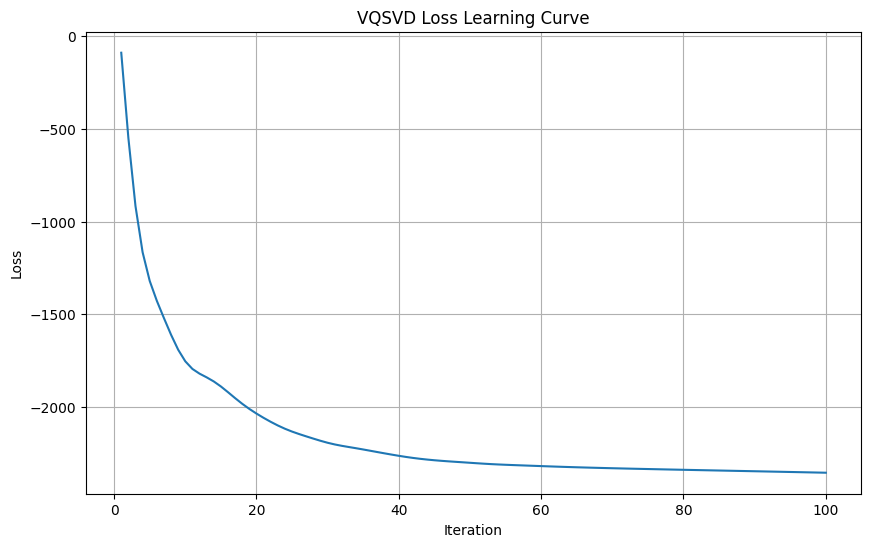

Plot saved as ./results/svd_comparison.png


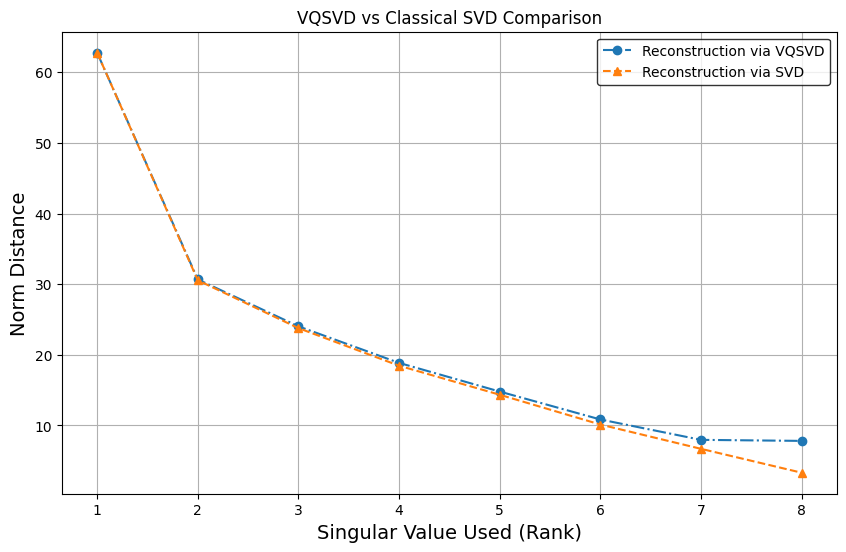

Running Image Reconstruction Experiment
Image matrix shape: (32, 32)
Demonstrating classical SVD reconstruction...
Plot saved as ./results/classical_svd_rank_5.png


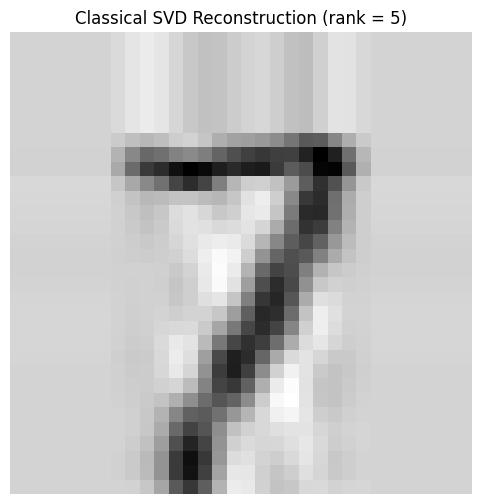

Plot saved as ./results/classical_svd_rank_10.png


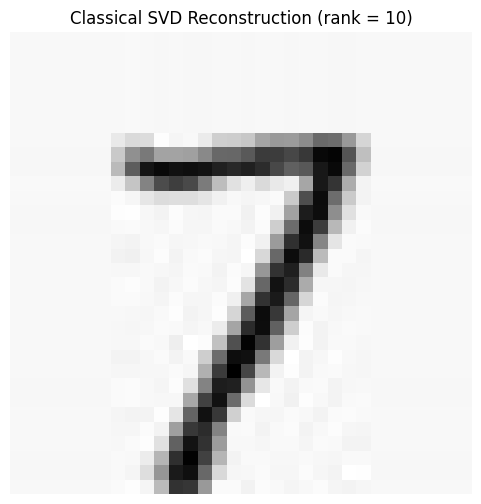

Plot saved as ./results/classical_svd_rank_15.png


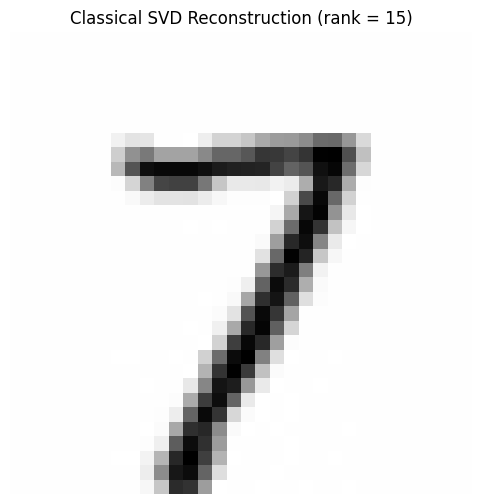

iter: 0, loss: 15.3047
iter: 10, loss: -427.7176
iter: 20, loss: -488.8746
iter: 30, loss: -533.4185
iter: 40, loss: -561.8018
iter: 50, loss: -579.1544
iter: 60, loss: -589.8535
iter: 70, loss: -595.8417
iter: 80, loss: -599.5245
iter: 90, loss: -601.9962
iter: 100, loss: -603.8158
iter: 110, loss: -605.1321
iter: 120, loss: -606.1506
iter: 130, loss: -607.0181
iter: 140, loss: -607.8245
iter: 150, loss: -608.6103
iter: 160, loss: -609.3924
iter: 170, loss: -610.1723
iter: 180, loss: -610.9442
iter: 190, loss: -611.6972
Plot saved as ./results/loss_curve.png


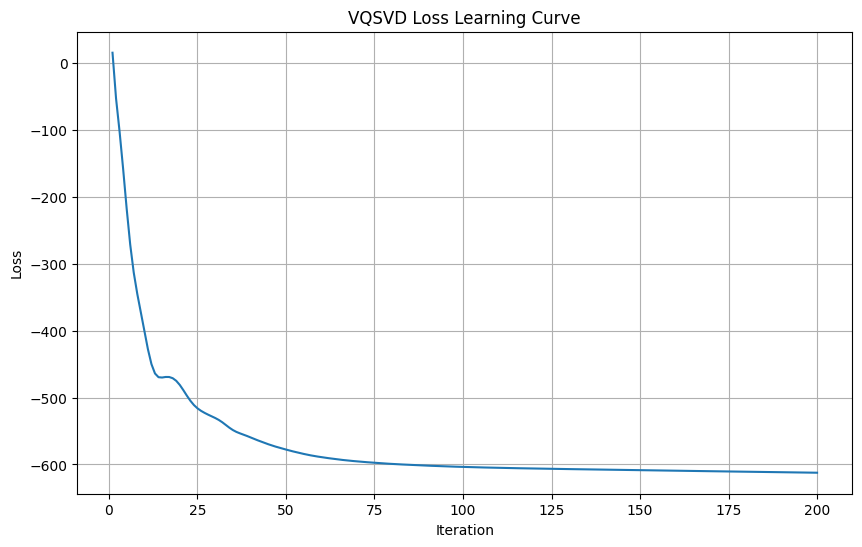

Plot saved as ./results/matrix_image.png


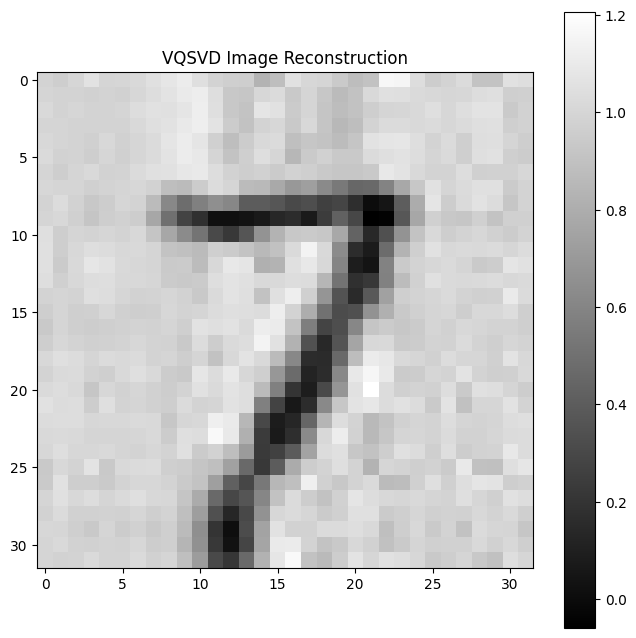

In [16]:

def main():
    """Main function to run VQSVD experiments"""
    experiment = VQSVDExperiment()

    # Run different experiments
    print("Starting VQSVD Experiments...")

    # 1. Pauli matrix experiment
    experiment.run_pauli_matrix_experiment()

    # 2. Random matrix experiment
    experiment.run_random_matrix_experiment()

    # 3. Image experiment (if image is available)
    try:
        experiment.run_image_experiment('./figures/MNIST_32.png')
    except Exception as e:
        print(f"Image experiment failed: {e}")
        print("Skipping image experiment...")


if __name__ == "__main__":
    main()